In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.path import Path
import yaml
import h5py

In [2]:
with open("yaml/2d_det_3x2_fov_114x114_panelID_00.yaml") as f:
    config = yaml.safe_load(f)

In [3]:
from typing import TypedDict

Transform = TypedDict("Transform", {"angle": float, "trans_r": float, "trans_t": float})


def transform_verts(verts: np.ndarray, trans: Transform) -> np.ndarray:
    angle = np.deg2rad(trans["angle"])
    trans_r = trans["trans_r"]
    trans_t = trans["trans_t"]
    mtrans = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.array(
        [np.matmul(mtrans, vert + np.array([trans_r, trans_t])) for vert in verts]
    )


def geom2verts(geom: np.ndarray, trans: Transform) -> np.ndarray:
    verts = np.array(
        [
            [geom[0], geom[2]],
            [geom[1], geom[2]],
            [geom[1], geom[3]],
            [geom[0], geom[3]],
            [geom[0], geom[2]],
        ]
    )
    return transform_verts(verts, trans)


def verts_to_patch(verts: np.ndarray) -> PatchCollection:
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts, codes)
    return patches.PathPatch(path, facecolor="orange", ec="none")


def geoms_to_patchcollection(
    geoms: np.ndarray, trans_list: list[Transform], fc: str = "orange", ec: str = "none"
) -> matplotlib.patches.PathPatch:
    verts_list = []
    for trans in trans_list:
        for geom in geoms:
            verts_list.append(geom2verts(geom, trans))
    return PatchCollection(
        [verts_to_patch(verts) for verts in verts_list], fc=fc, ec=ec
    )


def get_det_geoms(yamlConfig):
    indices = np.asarray(
        yamlConfig["detector"]["active geometry indices"], dtype=np.int32
    )
    active_dets = []
    for idx in indices:
        active_dets.append(geoms[geoms[:, 6] == idx][0])
    return np.array(active_dets)


def get_geom_center_xy(geom):
    return (geom[:4:2] + geom[1:4:2]) * 0.5

/tmp/ipykernel_13492/143753789.py:94: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


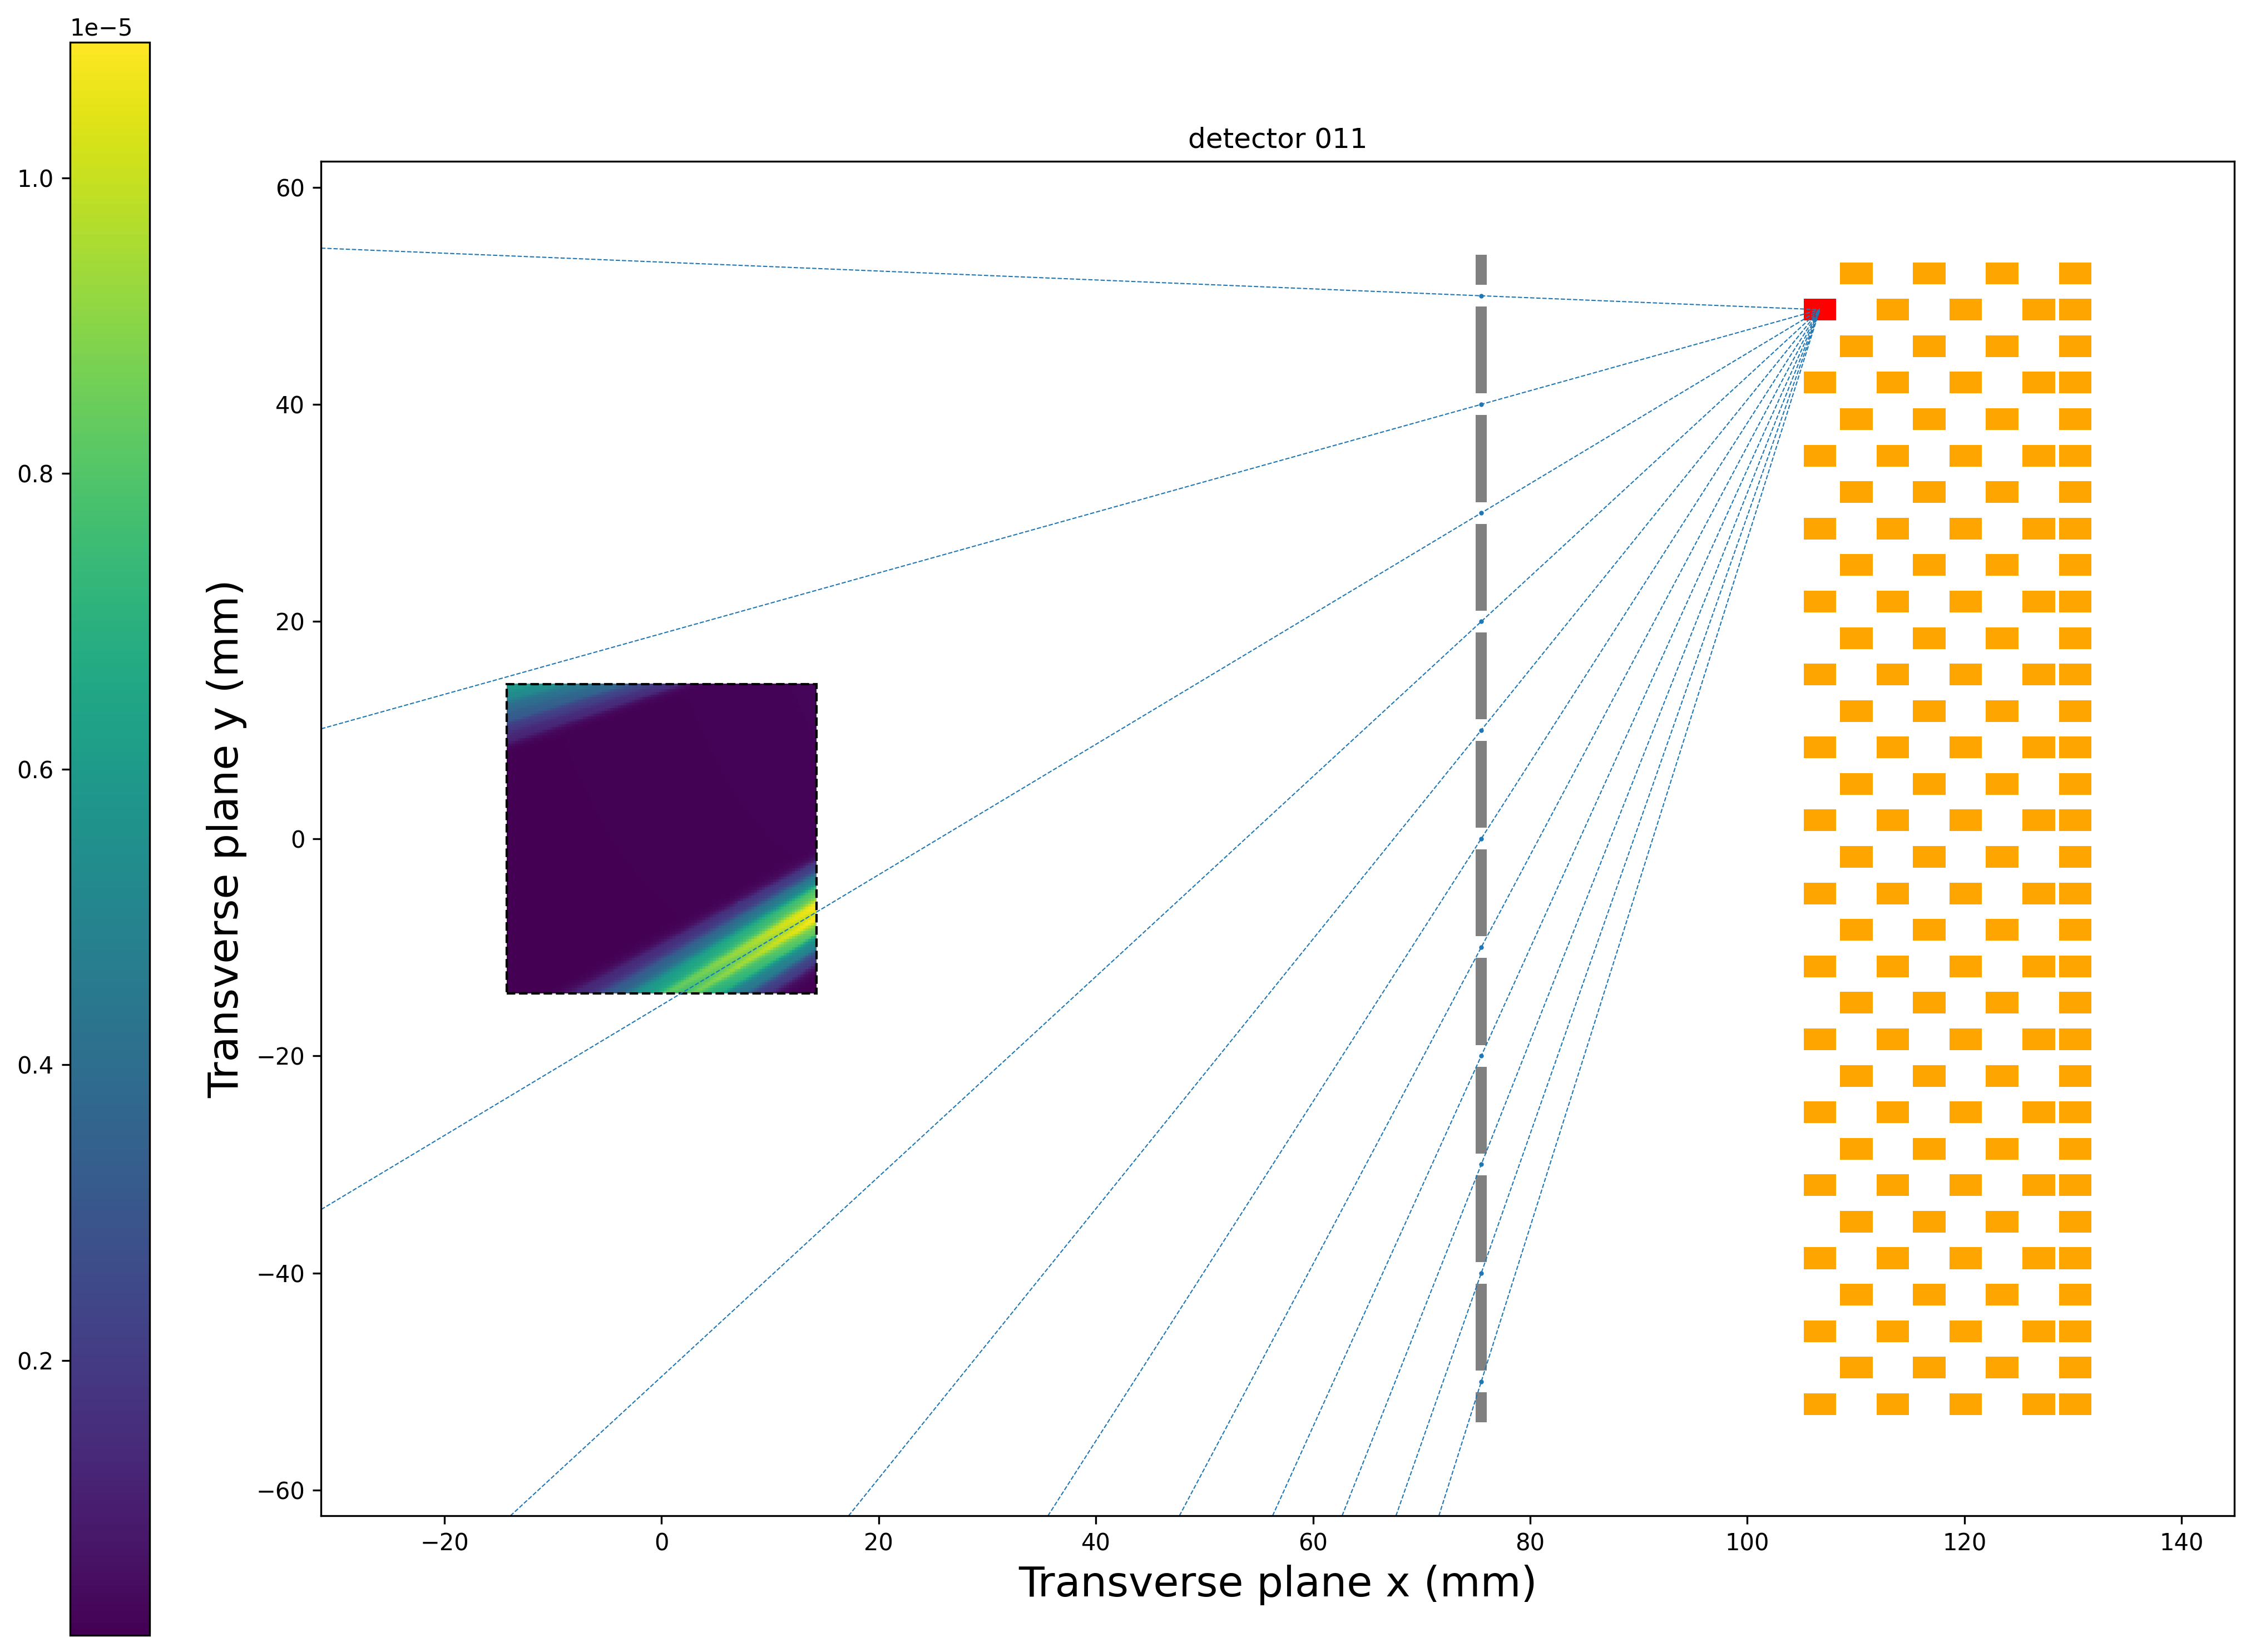

In [5]:

fov_dims = np.array(config["FOV"]["N voxels xyz"]) * np.array(
    config["FOV"]["mm per voxel xyz"]
)
geoms = np.array(config["detector"]["detector geometry"])

trans_t = -(np.max(geoms[:, 3]) + np.min(geoms[:, 2])) / 2
det_dims = np.array(
    [
        np.max(geoms[:, 1]) - np.min(geoms[:, 0]),
        np.max(geoms[:, 3]) - np.min(geoms[:, 2]),
        np.max(geoms[:, 5]) - np.min(geoms[:, 4]),
    ]
)

trans_r = config["relation"]["radial shift"]["data"][0]
trans_list = [
    {
        "angle": config["relation"]["rotation"]["data"][0],
        "trans_r": trans_r,
        "trans_t": trans_t,
    }
]

# patch = verts2rect(transform_verts(verts,trans))
active_det_geoms = geoms[geoms[:, 6] != 0]
plate_geoms = geoms[geoms[:, 6] == 0]


with h5py.File("data/2d_det_3x2_fov_114x114_panelID_00.hdf5", "r") as f:
    data = f["sysmat"]
    gid = 11
    fov_nvx = np.array(config["FOV"]["N voxels xyz"])[0:2]
    # ppdf = np.empty((fov_nvx))
    det_geoms = get_det_geoms(config)
    fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
    ppdf = data[0, 0, 0, gid].reshape((fov_nvx[0], fov_nvx[1]))

    ax.add_patch(
        plt.Rectangle(
            -fov_dims * 0.5, fov_dims[0], fov_dims[1], fc="none", ec="k", ls="--"
        )
    )
    det_coll = geoms_to_patchcollection(active_det_geoms, trans_list)
    plate_coll = geoms_to_patchcollection(plate_geoms, trans_list, fc="gray")
    coll = geoms_to_patchcollection(geoms, trans_list)
    ax.add_collection(det_coll)
    ax.add_collection(plate_coll)
    # ax.add_collection(coll)
    # ax.set_xlim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
    # ax.set_ylim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
    ax.set_xlim((fov_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
    ax.set_ylim((det_dims[0]) * (-1.1), (det_dims[0]) * 1.1)
    ax.set_aspect("equal")
    this_geom = np.array([det_geoms[gid]])
    geom_center_xy = transform_verts(
        [get_geom_center_xy(det_geoms[gid])],
        {"angle": 0, "trans_r": trans_r, "trans_t": trans_t},
    )
    # print(this_geom)
    this_geom_coll = geoms_to_patchcollection(this_geom, trans_list, fc="r")
    aperture_y = (plate_geoms[:-1,3]+plate_geoms[1:,2])*0.5+trans_t
    aperture_centers = np.stack(
        (np.full(aperture_y.shape[0], trans_r + 0.5), aperture_y)
    ).T
    ax.add_collection(this_geom_coll)
    cb = fig.colorbar(
        ax.imshow(
            ppdf,
            extent=(
                -fov_dims[0] * 0.5,
                fov_dims[0] * 0.5,
                -fov_dims[1] * 0.5,
                fov_dims[1] * 0.5,
            ),
            origin="lower",
        ),
        location="left",
        pad=0.07,
    )
    clipbox = plt.Rectangle(
        (ax.get_xlim()[0], ax.get_ylim()[0]),
        geom_center_xy[0, 0] - ax.get_xlim()[0],
        ax.get_ylim()[1] - ax.get_ylim()[0],
        transform=ax.transData,
    )

    ax.plot(aperture_centers[:, 0], aperture_centers[:, 1], "o", ms=1)
    for pA in aperture_centers:
        line = ax.axline(geom_center_xy[0], pA, ls="--", lw=0.5)
        line.set_clip_path(clipbox)
    ax.set_xlabel("Transverse plane x (mm)",fontsize=18)
    ax.set_ylabel("Transverse plane y (mm)",fontsize=18)
    fig.tight_layout()
    fig.show()
    ax.set_title("detector %03d" % gid)
    del det_coll, plate_coll, coll, fig, ax

In [4]:
plt.ioff()
fov_dims = np.array(config["FOV"]["N voxels xyz"]) * np.array(
    config["FOV"]["mm per voxel xyz"]
)
geoms = np.array(config["detector"]["detector geometry"])

trans_t = -(np.max(geoms[:, 3]) + np.min(geoms[:, 2])) / 2
det_dims = np.array(
    [
        np.max(geoms[:, 1]) - np.min(geoms[:, 0]),
        np.max(geoms[:, 3]) - np.min(geoms[:, 2]),
        np.max(geoms[:, 5]) - np.min(geoms[:, 4]),
    ]
)

trans_r = config["relation"]["radial shift"]["data"][0]
trans_list = [
    {
        "angle": config["relation"]["rotation"]["data"][0],
        "trans_r": trans_r,
        "trans_t": trans_t,
    }
]

# patch = verts2rect(transform_verts(verts,trans))
active_det_geoms = geoms[geoms[:, 6] != 0]
plate_geoms = geoms[geoms[:, 6] == 0]


with h5py.File("2d_det_3x2_fov_114x114_panelID_00.hdf5", "r") as f:
    data = f["sysmat"]
    gid = 11
    fov_nvx = np.array(config["FOV"]["N voxels xyz"])[0:2]
    # ppdf = np.empty((fov_nvx))
    det_geoms = get_det_geoms(config)
    fig, ax = plt.subplots(figsize=(15, 10), dpi=300)
    for gid in [0, 10, 25, 67, 120]:
        ppdf = data[0, 0, 0, gid].reshape((fov_nvx[0], fov_nvx[1]))

        ax.add_patch(
            plt.Rectangle(
                -fov_dims * 0.5, fov_dims[0], fov_dims[1], fc="none", ec="k", ls="--"
            )
        )
        det_coll = geoms_to_patchcollection(active_det_geoms, trans_list)
        plate_coll = geoms_to_patchcollection(plate_geoms, trans_list, fc="gray")
        coll = geoms_to_patchcollection(geoms, trans_list)
        ax.add_collection(det_coll)
        ax.add_collection(plate_coll)
        # ax.add_collection(coll)
        # ax.set_xlim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
        # ax.set_ylim((trans_r + det_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
        ax.set_xlim((fov_dims[0]) * (-1.1), (trans_r + det_dims[0]) * 1.1)
        ax.set_ylim((det_dims[0]) * (-1.1), (det_dims[0]) * 1.1)
        ax.set_aspect("equal")
        this_geom = np.array([det_geoms[gid]])
        geom_center_xy = transform_verts(
            [get_geom_center_xy(det_geoms[gid])],
            {"angle": 0, "trans_r": trans_r, "trans_t": trans_t},
        )
        # print(this_geom)
        this_geom_coll = geoms_to_patchcollection(this_geom, trans_list, fc="r")

        aperture_centers = np.stack(
            (np.full(aperture_y.shape[0], trans_r + 0.5), aperture_y)
        ).T
        ax.add_collection(this_geom_coll)
        cb = fig.colorbar(
            ax.imshow(
                ppdf,
                extent=(
                    -fov_dims[0] * 0.5,
                    fov_dims[0] * 0.5,
                    -fov_dims[1] * 0.5,
                    fov_dims[1] * 0.5,
                ),
                origin="lower",
            ),
            location="left",
            pad=0.07,
        )
        clipbox = plt.Rectangle(
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            geom_center_xy[0, 0] - ax.get_xlim()[0],
            ax.get_ylim()[1] - ax.get_ylim()[0],
            transform=ax.transData,
        )

        ax.plot(aperture_centers[:, 0], aperture_centers[:, 1], "o", ms=1)
        for pA in aperture_centers:
            line = ax.axline(geom_center_xy[0], pA, ls="--", lw=0.5)
            line.set_clip_path(clipbox)
        ax.set_xlabel("Transverse plane x (mm)",fontsize=18)
        ax.set_ylabel("Transverse plane y (mm)",fontsize=18)
        fig.tight_layout()
        ax.set_title("detector %03d" % gid)
        fig.savefig("detector %03d" % gid)
        cb.remove()
        ax.cla()
        del det_coll, plate_coll, coll
    del fig, ax

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '2d_det_3x2_fov_114x114_panelID_00.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
aperture_y = (plate_geoms[:-1,3]+plate_geoms[1:,2])*0.5+trans_t
print(aperture_y)

In [ ]:
aperture_centers=np.stack((np.full(aperture_y.shape[0], trans_r + 0.5), aperture_y)).T
print(aperture_centers.shape)

In [ ]:
geom_center_xy = transform_verts([get_geom_center_xy(det_geoms[gid])],{"angle": 0, "trans_r": trans_r, "trans_t": trans_t })
print(geom_center_xy)

In [ ]:
geom_center_xy = get_geom_center_xy(det_geoms[gid])
print(geom_center_xy)